# axe testing codes as dataframes and exceptions

in accessibility testing there are two modes:

1. one mode where you are testing a baseline
2. one mode where you have errors in the baseline, and trying to address to errors.

as we work through the tidy data representation of the axe codes we'll understand more of the landscape that axe covers in their automated tests.
we'll have a birds eye of what is tested. these tests then need to make sense in automated testing scenarios beyond a 👍/👎. 
it is important that downstreams user can reason with continuous test results, and promptly resolve automated inaccessibles. 
improvements to the testing resolution should help developers resolve issues.

In [66]:
    import pandas, requests, markdown_it, io, networkx, matplotlib, numpy
    from toolz.curried import *; f = compose = compose_left

## the axe codes

axe has tests for a varied accessibility conditions. the list of categories/tags are available @ https://raw.githubusercontent.com/dequelabs/axe-core/master/doc/rule-descriptions.md

In [67]:
    page = requests.get("https://raw.githubusercontent.com/dequelabs/axe-core/master/doc/rule-descriptions.md")
    MD = markdown_it.MarkdownIt("gfm-like")

## load the rules into a dataframe

it is possible to extra tables as dataframes after we convert the markdown to html.

In [68]:
    rules, *_ = pandas.read_html(io.StringIO(MD.render(page.text)), extract_links="body")

this next unit of work separates urls from their content.

In [69]:
    rules = rules.join(
        rules[["ACT Rules", "Rule ID"]]
        .stack().apply(f(list, pandas.Series))
        .rename(columns=dict(enumerate("value url".split())))
        .unstack().pipe(
            lambda df: df[df.map(bool).any(axis=1)]
        )["url"].map(juxt(identity)), rsuffix="_url"
    )
    rules = rules.map(lambda x: x[0])

tidy up the dataframe

In [70]:
    rules.columns = pipe(rules.columns, map(f(str.lower, str.split, "_".join)))
    rules = rules.set_index("rule_id")
    rules.T

rule_id,area-alt,aria-allowed-attr,aria-braille-equivalent,aria-command-name,aria-conditional-attr,aria-deprecated-role,aria-hidden-body,aria-hidden-focus,aria-input-field-name,aria-meter-name,...,object-alt,role-img-alt,scrollable-region-focusable,select-name,server-side-image-map,svg-img-alt,td-headers-attr,th-has-data-cells,valid-lang,video-caption
description,Ensures <area> elements of image maps have alt...,Ensures an element's role supports its ARIA at...,Ensure aria-braillelabel and aria-brailleroled...,"Ensures every ARIA button, link and menuitem h...",Ensures ARIA attributes are used as described ...,Ensures elements do not use deprecated roles,"Ensures aria-hidden=""true"" is not present on t...",Ensures aria-hidden elements are not focusable...,Ensures every ARIA input field has an accessib...,Ensures every ARIA meter node has an accessibl...,...,Ensures <object> elements have alternate text,"Ensures [role=""img""] elements have alternate text",Ensure elements that have scrollable content a...,Ensures select element has an accessible name,Ensures that server-side image maps are not used,"Ensures <svg> elements with an img, graphics-d...",Ensure that each cell in a table that uses the...,Ensure that <th> elements and elements with ro...,Ensures lang attributes have valid values,Ensures <video> elements have captions
impact,Critical,Critical,Serious,Serious,Serious,Minor,Critical,Serious,Serious,Serious,...,Serious,Serious,Serious,Critical,Minor,Serious,Serious,Serious,Serious,Critical
tags,"cat.text-alternatives, wcag2a, wcag244, wcag41...","cat.aria, wcag2a, wcag412, EN-301-549, EN-9.4.1.2","cat.aria, wcag2a, wcag412, EN-301-549, EN-9.4.1.2","cat.aria, wcag2a, wcag412, TTv5, TT6.a, EN-301...","cat.aria, wcag2a, wcag412, EN-301-549, EN-9.4.1.2","cat.aria, wcag2a, wcag412, EN-301-549, EN-9.4.1.2","cat.aria, wcag2a, wcag412, EN-301-549, EN-9.4.1.2","cat.name-role-value, wcag2a, wcag412, TTv5, TT...","cat.aria, wcag2a, wcag412, TTv5, TT5.c, EN-301...","cat.aria, wcag2a, wcag111, EN-301-549, EN-9.1.1.1",...,"cat.text-alternatives, wcag2a, wcag111, sectio...","cat.text-alternatives, wcag2a, wcag111, sectio...","cat.keyboard, wcag2a, wcag211, TTv5, TT4.a, EN...","cat.forms, wcag2a, wcag412, section508, sectio...","cat.text-alternatives, wcag2a, wcag211, sectio...","cat.text-alternatives, wcag2a, wcag111, sectio...","cat.tables, wcag2a, wcag131, section508, secti...","cat.tables, wcag2a, wcag131, section508, secti...","cat.language, wcag2aa, wcag312, TTv5, TT11.b, ...","cat.text-alternatives, wcag2a, wcag122, sectio..."
issue_type,"failure, needs review","failure, needs review",needs review,"failure, needs review",failure,failure,failure,"failure, needs review","failure, needs review","failure, needs review",...,"failure, needs review","failure, needs review",failure,"failure, needs review",needs review,"failure, needs review","failure, needs review","failure, needs review",failure,needs review
act_rules,c487ae,5c01ea,,97a4e1,5c01ea,674b10,,6cfa84,e086e5,,...,8fc3b6,23a2a8,0ssw9k,e086e5,,7d6734,a25f45,d0f69e,de46e4,eac66b
act_rules_url,https://act-rules.github.io/rules/c487ae,https://act-rules.github.io/rules/5c01ea,None,https://act-rules.github.io/rules/97a4e1,https://act-rules.github.io/rules/5c01ea,https://act-rules.github.io/rules/674b10,None,https://act-rules.github.io/rules/6cfa84,https://act-rules.github.io/rules/e086e5,None,...,https://act-rules.github.io/rules/8fc3b6,https://act-rules.github.io/rules/23a2a8,https://act-rules.github.io/rules/0ssw9k,https://act-rules.github.io/rules/e086e5,None,https://act-rules.github.io/rules/7d6734,https://act-rules.github.io/rules/a25f45,https://act-rules.github.io/rules/d0f69e,https://act-rules.github.io/rules/de46e4,https://act-rules.github.io/rules/eac66b
rule_id_url,https://dequeuniversity.com/rules/axe/4.8/area...,https://dequeuniversity.com/rules/axe/4.8/aria...,https://dequeuniversity.com/rules/axe/4.8/aria...,https://dequeuniversity.com/rules/axe/4.8/aria...,https://dequ

## extract all the unique tags

https://www.deque.com/en-301-549-compliance/
https://www.un.org/development/desa/disabilities/convention-on-the-rights-of-persons-with-disabilities/article-9-accessibility.html
https://www.dhs.gov/trusted-tester
section 508

In [76]:
    tags = rules.tags.str.split(",", expand=True).fillna("").map(str.strip).apply(
        
        f(lambda x: {x: True for x in x if x}, pandas.Series), axis=1
    ).fillna(False).astype(int)
    tags.T.style.set_caption("the tags associated with each axe rule")


rule_id,area-alt,aria-allowed-attr,aria-braille-equivalent,aria-command-name,aria-conditional-attr,aria-deprecated-role,aria-hidden-body,aria-hidden-focus,aria-input-field-name,aria-meter-name,aria-progressbar-name,aria-prohibited-attr,aria-required-attr,aria-required-children,aria-required-parent,aria-roles,aria-toggle-field-name,aria-tooltip-name,aria-valid-attr-value,aria-valid-attr,blink,button-name,bypass,color-contrast,definition-list,dlitem,document-title,duplicate-id-aria,form-field-multiple-labels,frame-focusable-content,frame-title-unique,frame-title,html-has-lang,html-lang-valid,html-xml-lang-mismatch,image-alt,input-button-name,input-image-alt,label,link-in-text-block,link-name,list,listitem,marquee,meta-refresh,meta-viewport,nested-interactive,no-autoplay-audio,object-alt,role-img-alt,scrollable-region-focusable,select-name,server-side-image-map,svg-img-alt,td-headers-attr,th-has-data-cells,valid-lang,video-caption
ACT,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0
EN-301-549,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
EN-9.1.1.1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0
EN-9.1.2.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
EN-9.1.3.1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
EN-9.1.4.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
EN-9.1.4.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
EN-9.1.4.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
EN-9.1.4.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
EN-9.2.1.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


### topology of the axe tag network

we find a high level understanding of the relationship between the tags when we look at different layouts of the network.s

In [77]:
    adjacency = tags.values.T @ tags.values
    adjacency = adjacency - adjacency * numpy.identity(adjacency.shape[0])
    G = pandas.DataFrame(adjacency, tags.columns, tags.columns).pipe(networkx.from_pandas_adjacency)

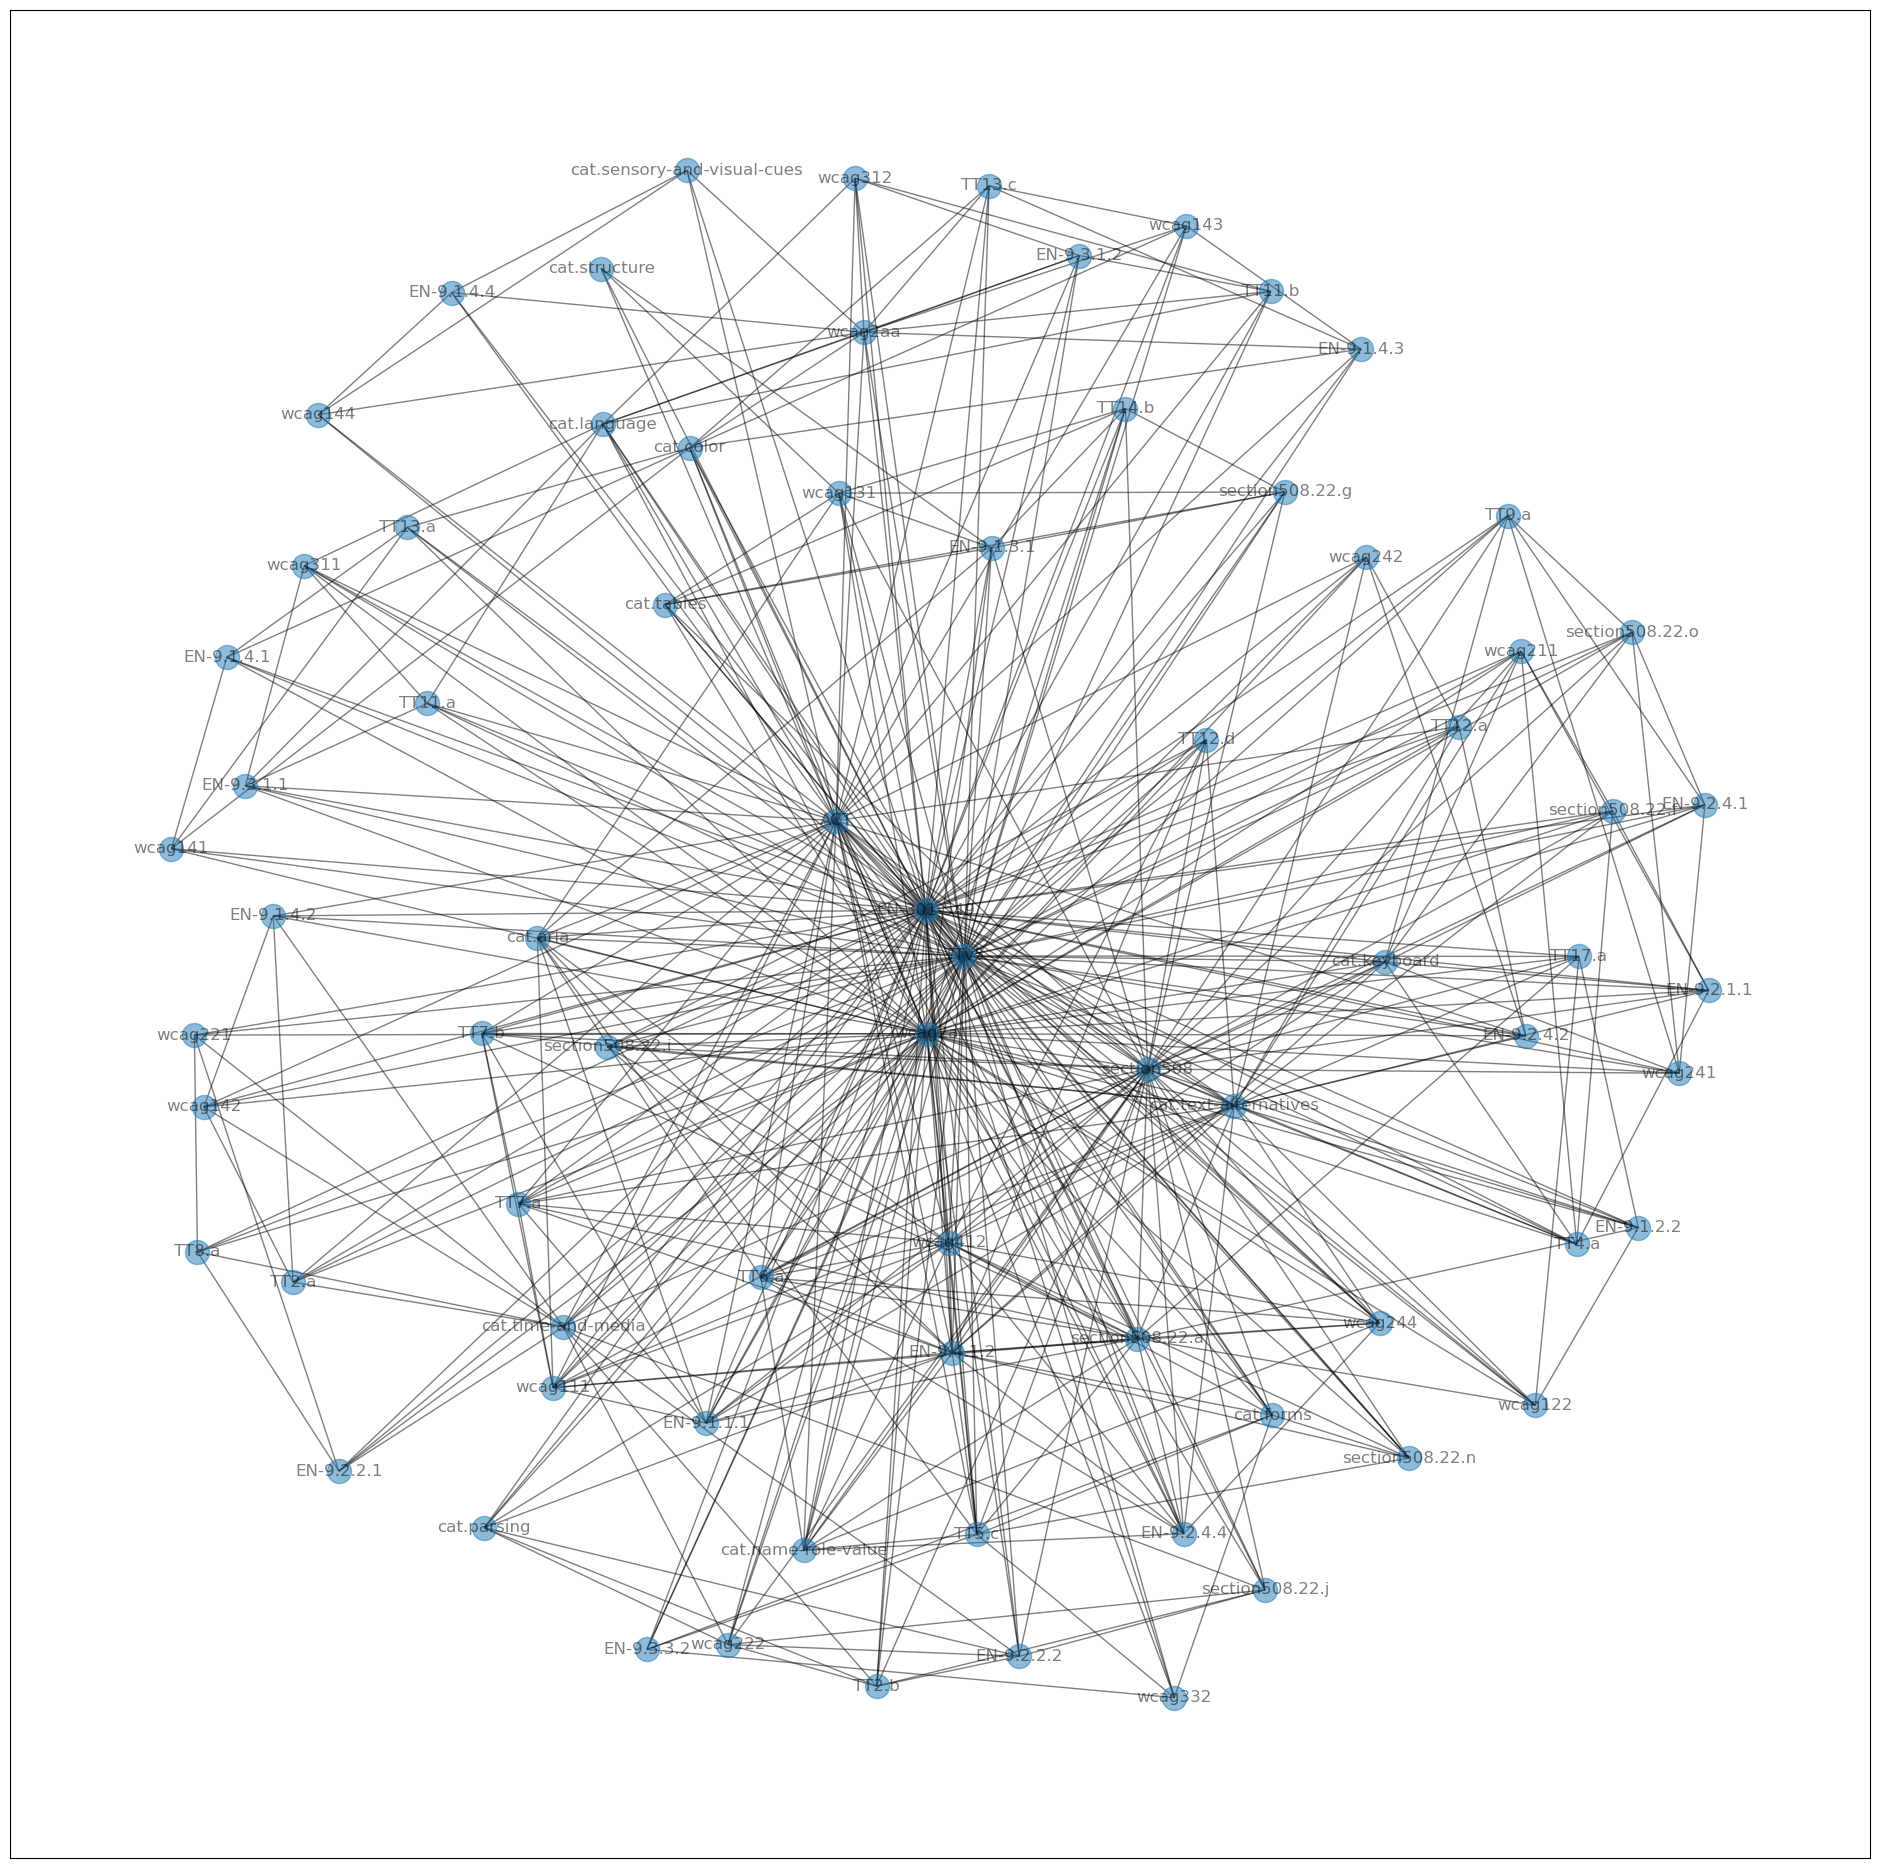

In [79]:
    networkx.draw_networkx(G, networkx.nx_agraph.graphviz_layout(G), alpha=.5)
    matplotlib.pyplot.gcf().set_size_inches(24, 24)


## creating exceptions